# Header

In [1]:
import os

## Notebook Configuration

In [2]:
# path to the this notebook
# NOTE: Replace this with your project path if needed
PROJECT_PATH = (
    "/content/drive/My Drive/Colab Notebooks"
    if "google.colab" in str(get_ipython())
    else "."
)

# path to the data folder
# NOTE: Replace this with your data path if needed
DATA_PATH = f"{PROJECT_PATH}/data" if "google.colab" in str(get_ipython()) else PROJECT_PATH
# NOTE: For colab we use content so it doesn't load on google drive storage
RAW_DATA_PATH = f"{PROJECT_PATH}/data" if "google.colab" in str(get_ipython()) else f"{PROJECT_PATH}/data"

## Colab Setup

In [3]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    # setup libraries used by notebook
    #os.system("pip install -q kaggle")

os.chdir(PROJECT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Library Import

In [4]:
import itertools
import json
import requests
import shutil
import typing
import zipfile

from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

## Functions

In [5]:
def download_from_web(
    save_path: typing.Union[str, Path, typing.IO[bytes], typing.BinaryIO],
    url: str,
    block_size: int = 300 * 1024,
) -> typing.Union[typing.IO[bytes], typing.BinaryIO]:
    """
    Perform download of a file from a public web adress

    :param save_path: path to save the data extraction
    :param url: address where data is stored
    :param block_size: size in bytes from incremental download
    :return: buffer object to file
    """
    # make sure the path points to an buffer object
    if isinstance(save_path, str) or isinstance(save_path, Path):
        file_path: typing.Union[typing.IO[bytes], typing.BinaryIO] = open(save_path, "wb")
    else:
        file_path = save_path

    # generate a request to get the content
    response = requests.get(url, stream=True)
    total_size_in_bytes = int(response.headers.get("content-length", 0))

    # parse the file
    progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        file_path.write(data)
    file_path.close()

    # returns the buffer object
    return file_path

---

# Data Load

In [6]:
fda = pd.read_csv(f"{DATA_PATH}/FDA_data.csv", dtype=str)

# Data Pre-Processing

In [7]:
# calculate the shortage indicators
# 1. Remove NDC codes that are not valid
# 2. Create a row id for each shortage report (NDC + Created pair)
# 3. Remove shortage status which indicate availability
# 4. Calculate the shortage start and end dates
# 5. Extend the shortage values
remove = [
    "Available",
    "Available, We Have Adequate Inventory To Support Demand",
    "Available - New Launch",
    "Available, N/A",
    "Available; Currently Have 7.5 Months Of Coverage"
]
shortages = (
    fda[
        (~fda["Availability"].isin(["Discontinued", "No Longer Available"]))
        & (fda["Shortage_Status"] != "Discontinued")
        & (fda["NDC"].notnull())
        & (fda["NDC"].str.len() == 11)
    ]
    .sort_values(by=["NDC", "Created", "latest_date"])
    .reset_index(drop=True)
    .assign(row_id=lambda f: f.groupby(["NDC", "Created"])["latest_date"].cumcount())
    .loc[lambda f: ~f["Availability"].isin(remove)]
    .assign(
        Created=lambda f: pd.to_datetime(f["Created"], format="%m/%d/%Y"),
        latest_date=lambda f: pd.Series(pd.to_datetime(f["latest_date"])).dt.date,
        shortage_start=lambda f: np.where(f["row_id"] == 0, f["Created"], pd.to_datetime(f["latest_date"])),
        shortage_end=lambda f: pd.to_datetime(f["latest_date"]),
        resolved_date=lambda f: np.where(f["Shortage_Status"] == "Resolved", f["shortage_end"], None),
    )
    .assign(resolved_date=lambda f: pd.to_datetime(f["resolved_date"].fillna("2030-12-31")))
    .groupby(["NDC", "Created"], as_index=False)
    .agg({"shortage_start": "min", "resolved_date": "min", "shortage_end": "max"})
    .assign(shortage_end=lambda f: np.where(f["resolved_date"] < "2030-12-31", f["resolved_date"], f["shortage_end"]))
    .rename(columns={"NDC": "ndc"})
    .assign(date=lambda f: f.apply(lambda row: pd.date_range(row["shortage_start"], row["shortage_end"]), axis=1))
    .drop(columns=["Created", "shortage_start", "resolved_date", "shortage_end"])
    .explode("date")
    .reset_index(drop=True)
    .assign(shortage_indicator=1)
)

<Axes: xlabel='date'>

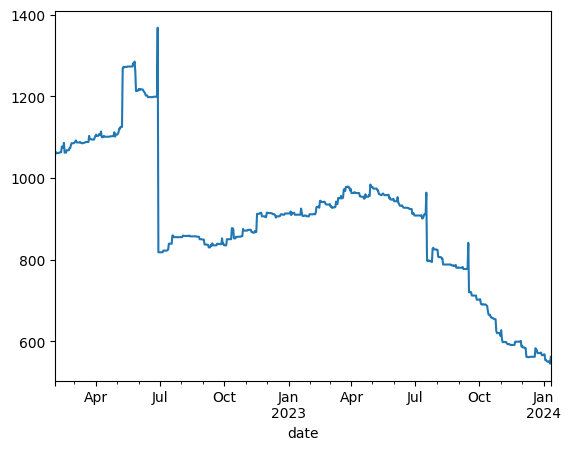

In [8]:
shortages.loc[lambda f: f["date"] >= "2022-02-01"].groupby("date")["shortage_indicator"].sum().plot()

# Export

In [9]:
shortages.to_parquet(f"{DATA_PATH}/preprocessed/shortages.parquet", index=False)

---